# p-value computation and conversion: one-sided, two-sided?

This is an attempt to clear up the confusion around p-value computation and based on the authorative source on that matter:

[G. Cowan, K. Cranmer, E. Gross, O. Vitells, Eur.Phys.J.C 71 (2011) 1554](https://inspirehep.net/literature/860907)

The point of that paper is that one should use two different test statistics based on the likelihood-ratio for deviations that are always positive and for deviations where the sign is not known a priori. One gets two different p-values accordingly. The conversion to significance is then always the same.

I generate a flat distribution from $(-1,1)$ which represents background-only samples, then I fit a Gaussian peak centered at 0 with width 0.1 to this data test the two hypotheses

* $H_0$: there is only background
* $H_1$: there is background and a signal

The $H_1$ in these kinds of tests is never arbitrary in terms of the signal, we do not seek for any deviation, but a rather specific one. In our example, we seek for a signal in particular location (here centered at 0). This is important for the computation of the p-value later. The less constrained $H_1$ is, the more of the Look-Elsewhere Effect I get, because more random fluctuations of the background can be confused with a signal.

When fitting the toys, I allow the amplitude $\mu$ of the signal to be positive or negative (following Cowan et al.). As a test statistic for a deviation from the background-only case I use $t_0$ (again following Cowan et al. in the notation)
$$
t_0 = -2\ln \lambda(0) = -2 \ln \frac{L(0, \hat {\hat \theta})}{L(\hat \mu, \hat \theta)}
$$
where
* $\mu$ is the amplitude of the hypothetical signal
* $\theta$ are nuisance parameters
* $\hat \mu$ is the fitted value of $\mu$
* $\hat\theta$ are the fitted values of $\theta$ when $\mu$ is also fitted
* $\hat{\hat\theta}$ are the fitted values of $\theta$ under the condition $\mu = 0$.

If you search for $t_0$ in the paper, it is not explicitly written there, $t_0$ is $t_\mu$ from section 2.1 with $\mu = 0$.

In [19]:
import numpy as np
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
from numba_stats import uniform_pdf, norm_pdf
import matplotlib.pyplot as plt
import boost_histogram as bh

In [3]:
rng = np.random.default_rng(1)

def model(x, mu, theta):
    return mu + theta, mu * norm_pdf(x, 0, 0.1) + theta * uniform_pdf(x, -1, 2)

positive = [0]
negative = [0]
t0 = []
mu = []
for imc in range(1000):
    b = rng.uniform(-1, 1, size=1000)
    c = ExtendedUnbinnedNLL(b, model)
    m = Minuit(c, mu=0, theta=len(b))
    m.limits["theta"] = (0, None)
    m.fixed["mu"] = True
    m.migrad()
    assert m.valid
    lnL_b = -m.fval
    m.fixed["mu"] = False
    m.migrad()
    mui = m.values["mu"]
    lnL_sb = -m.fval
    t0i = 2 * (lnL_sb - lnL_b)
    t0.append(t0i)
    mu.append(mui)
    if mui > 0 and t0i > positive[0]:
        h = bh.Histogram(bh.axis.Regular(100, -1, 1))
        h.fill(b)
        positive = (t0i, h, m.values[:], m.covariance[:])
    elif mui < 0 and t0i > negative[0]:
        h = bh.Histogram(bh.axis.Regular(100, -1, 1))
        h.fill(b)
        negative = (t0i, h, m.values[:], m.covariance[:])
        
t0 = np.array(t0)
mu = np.array(mu)

Let's look at the two most extreme deviations from $H_0$, the ones with the largest and smallest signal.

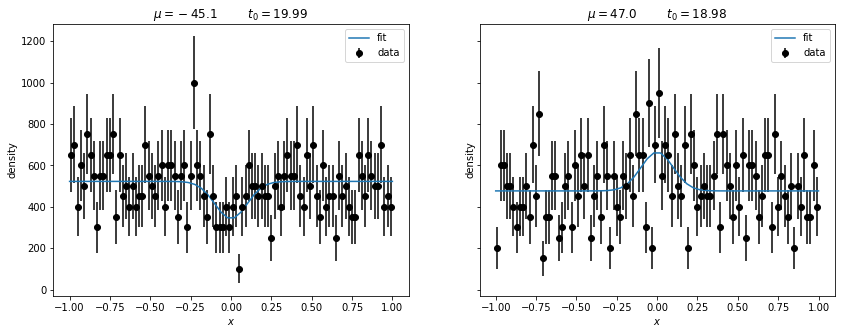

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)
for (t0i, h, par, cov), axi in zip((negative, positive), ax):
    plt.sca(axi)
    scale = 1/h.axes[0].widths
    plt.errorbar(h.axes[0].centers, h.values() * scale, h.variances()**0.5 * scale, fmt="ok", label="data")
    scale = 1 / h.axes[0].widths
    xm = np.linspace(-1, 1)
    plt.plot(xm, model(xm, *par)[1], label="fit")
    plt.legend()
    dev = par[0] / cov[0,0] ** 0.5
    plt.title(f"$\mu = {par[0]:.1f}$        $t_0 = {t0i:.2f}$")
    plt.ylabel("density")
    plt.xlabel("$x$")

Both upward and downward fluctuations are unlikely events  if $H_0$ is true and therefore both get a large value of our test statistic $t_0$, which does not know in which way the deviation went.

#### Searches with $\mu > 0$ (for a new particle, new decay mode, etc.)

In most cases we look for a positive peak (new particle, new decay mode, etc). If we see a downward fluctuation, we **know for sure** that this cannot be what we are looking for. Therefore, when we compute the p-value for some observation from a simulation like this one, we must not regard large values of the test statistic when the fluctuation was negative, since this is not a deviation of $H_0$ that mimics our signal. Instead we should set $t_0$ to zero in such cases. Cowan et al. use $q_0$ for this modified test statistic
$$
q_0 = \begin{cases}
t_0 &\text{if } \hat\mu \ge 0 \\
0 &\text{otherwise}
\end{cases}
$$

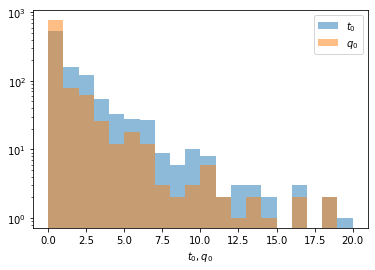

In [11]:
plt.hist(t0, alpha=0.5, bins=20, range=(0, 20), label="$t_0$")
q0 = t0.copy()
q0 = np.where(mu < 0, 0, t0)
plt.hist(q0, alpha=0.5, bins=20, range=(0, 20), label="$q_0$")
plt.legend()
plt.axhline()
plt.xlabel("$t_0, q_0$")
plt.semilogy();

If we observed $t_0 = q_0 = 15$ in a real experiment, we need to compare it with the $q_0$ distribution and not with the $t_0$ distribution to compute the p-value.

In [29]:
print(f"Wrong: p-value based on t0-distribution {np.mean(t0 > 15)}")
print(f"Right: p-value based on q0-distribution {np.mean(q0 > 15)}")

Wrong: p-value based on t0-distribution 0.006
Right: p-value based on q0-distribution 0.004


As we can see, the p-value is enhanced in this case, because we do not need to consider the negative fluctuations at all. The conversion to significance $Z$ is done with a normal distribution.

In [27]:
from scipy.stats import norm

p = np.mean(q0 > 15)
print(f"Z = {norm.ppf(1 - p):.2f}")

Z = 2.65


#### Searches for deviations where the sign of $\mu$ is not known a priori

If cannot exclude a priori that our signal has $\mu < 0$, we need to use the $t_0$ distribution instead of $q_0$.

If we observed $t_0 = 15$ in a real experiment, we need to compare it with $t_0$ distribution to compute the p-value.

In [31]:
print(f"Right: p-value based on t0-distribution {np.mean(t0 > 15)}")

Right: p-value based on t0-distribution 0.006


As we can see, the p-value is diluted in this case, because we need to consider fluctuations in both directions. In other words, the Look-Elsewhere Effect is larger in this case, because more kinds of fluctuations in the background can be confused with a signal.

In [26]:
from scipy.stats import norm

p = np.mean(t0 > 15)
print(f"Z = {norm.ppf(1 - p):.2f}")

Z = 2.51


Accordingly, the significance is a bit lower compared to the previous case.